In [1]:
import agent_code.vkl.models as models
from agent_code.vkl.data import MoveDataset
from torch.utils.data import DataLoader
from torch import load, save
import pytorch_lightning as L
import torch
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
from gc import collect

# Parameters

In [2]:
epochs = 250
batch_size = 512
torch.set_float32_matmul_precision("medium")
dtype = torch.float32
precision = "16-mixed"

# Data

In [7]:
# join 4 datasets
dir = "agent_code/watcher/output/"
filenames = [f for f in listdir(dir) if f[-3:] == ".pt"][:1]
paths = [join(dir, f) for f in filenames]
moves = sum([load(path, weights_only=False) for path in paths], [])

dataset = MoveDataset(moves)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=32,
    pin_memory=True,
    persistent_workers=True,
)
del moves
collect()

3877

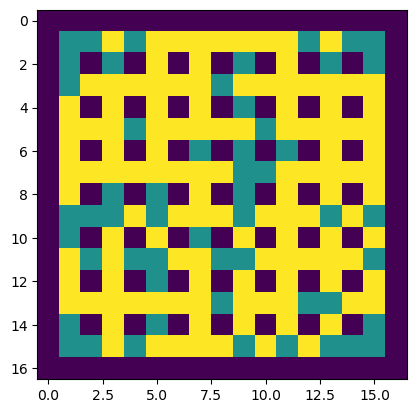

In [17]:
plt.imshow(dataset[0][0][0, ...])

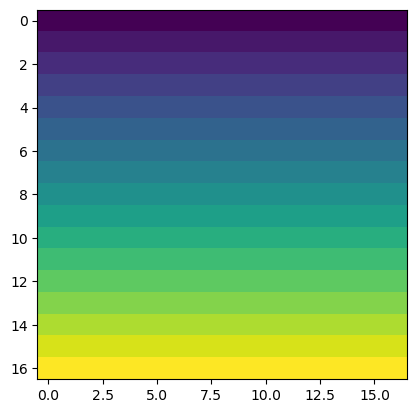

In [16]:
plt.imshow(dataset[0][0][-1, ...])

# Model definition

In [9]:
raw_model = models.BasicModel()
raw_model.to(dtype)
total_steps = epochs * len(dataloader)
model = models.LitBasicModel(raw_model, total_steps=total_steps)
# model = torch.compile(model) # doesn't work for now

final conv layer side: 15


# Training

In [10]:
trainer = L.Trainer(accelerator="gpu", max_epochs=epochs, precision=precision)
trainer.fit(model=model, train_dataloaders=dataloader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | BasicModel | 7.9 M  | train
---------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.784    Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
/nix/store/mbjjwad3fs1gzhr6gm77jpaagxm7lh7a-python3-3.12.5-env/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                         | 0/? [00:00<?, ?it/s]

RuntimeError: DataLoader worker (pid(s) 2135462, 2135463, 2135464, 2135465, 2135466, 2135467, 2135468, 2135469, 2135470, 2135471, 2135472, 2135473, 2135474, 2135475, 2135476, 2135477, 2135478, 2135479, 2135480, 2135481, 2135482, 2135483, 2135484, 2135485, 2135486, 2135487, 2135488, 2135489, 2135490, 2135491, 2135492, 2135493) exited unexpectedly

# Save the model

In [ ]:
save(raw_model, "agent_code/vkl/output/model.pt")